1. EDA

In [28]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
#!gdown 1B9d9EkAHTdhRF4oWDEozKBzgoSP1dD8L

In [31]:
pd.set_option("display.max_columns", None)

In [7]:
df = pd.read_json('/Users/dan/git_repo/movs/python/2q/MLOps/ML_piplie_project/transactions.txt', lines=True)

# 1. EDA

In [8]:
df.shape

(786363, 29)

In [9]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [11]:
p = df.isna().sum().sum()
print(f"Total NaN in Data: {p}")

df.describe()

Total NaN in Data: 0


,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


In [12]:
df.describe(include='object')

,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363
unique,776637,2490,5,5,6,4,19,165,1820,2184,4,1,1,1,1,1,1
top,2016-12-25T14:04:15,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,PURCHASE,,,,,,
freq,4,25613,774709,778511,315035,628787,202156,5103,33623,3819,745193,786363,786363,786363,786363,786363,786363


Most of columns normalized, but not all. I'll use catboost (boosting) - it does not need to normalize the rest of the data

## Target

In [14]:
df['isFraud'][0]

False

In [16]:
df['isFraud'] = df['isFraud'].apply(lambda x: 0 if x == False else 1)

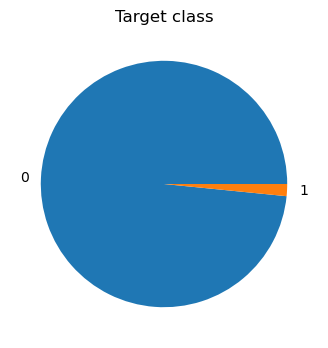

In [20]:
# Target plot
plt.figure(figsize=(4, 4))

df['isFraud'].value_counts().plot(kind="pie")
plt.title("Target class")
plt.ylabel("")
plt.xlabel("")
plt.show()

In [22]:
# Target counts
df["isFraud"].value_counts()

isFraud
0    773946
1     12417
Name: count, dtype: int64

___bad data___

In [48]:
bad_datat_list = [
    'recurringAuthInd', 'echoBuffer',  'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises'
]

In [49]:
for col in bad_datat_list:
    display(df[col].value_counts())
    print(' ')

echoBuffer
    786363
Name: count, dtype: int64

merchantCity
    786363
Name: count, dtype: int64

merchantState
    786363
Name: count, dtype: int64

merchantZip
    786363
Name: count, dtype: int64

posOnPremises
    786363
Name: count, dtype: int64

In [50]:
df = df.drop(bad_datat_list, axis=1)

___merchantName___

In [51]:
#df['merchantName'].value_counts().tail(50)

___BIN COLS___

In [56]:
df['cardPresent'] = df['cardPresent'] * 1
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'] * 1

In [57]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,0,0,0
1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,1,0,0
2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,0,0,0
3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,0,0,0
4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90,01,rideshare,12/2022,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1095.04,0,0,0
786359,732852505,732852505,50000,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,09,01,online_subscriptions,08/2023,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1214.96,0,0,0
786360,732852505,732852505,50000,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,02,01,rideshare,08/2025,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1233.85,0,0,0
786361,732852505,732852505,50000,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,09,99,online_retail,07/2022,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1283.28,0,0,0


# Modeling 

In [29]:
from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import CatBoostClassifier

In [61]:
time_drop = ['accountNumber', 'customerId', 'transactionDateTime', 'currentExpDate', 'accountOpenDate',  'dateOfLastAddressChange']

In [63]:
df = df.drop(time_drop,axis=1)

In [60]:
cat_cols = [
    'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 
    'posConditionCode', 'merchantCategoryCode', 'transactionType'
]

___prepaid data___

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("isFraud", axis=1),
    df["isFraud"],
    test_size=0.30,
    random_state=42,
    stratify=df["isFraud"],
)

In [65]:
# Split test on valid + test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

In [66]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [70]:
print(X_train.shape, y_train.sum())
print(X_valid.shape, y_valid.sum())
print(X_test.shape, y_test.sum())

(550454, 16) 8692
(117954, 16) 1862
(117955, 16) 1863


__model__

In [71]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [74]:
# Создаем экземпляр классификатора
params = {
    "verbose": 50,
    "random_seed": 42,
    "learning_rate": 0.05,
    "auto_class_weights": "Balanced",
    #'early_stopping_rounds' : 100,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
}


cb = CatBoostClassifier(**params)

In [75]:
# Обучаем модель на данных в Pool
cb.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7094745	best: 0.7094745 (0)	total: 285ms	remaining: 4m 44s
50:	test: 0.7544729	best: 0.7544729 (50)	total: 11s	remaining: 3m 25s
100:	test: 0.7741273	best: 0.7741273 (100)	total: 21.3s	remaining: 3m 9s
150:	test: 0.7809589	best: 0.7809589 (150)	total: 30.9s	remaining: 2m 53s
200:	test: 0.7889171	best: 0.7889171 (200)	total: 40.2s	remaining: 2m 39s
250:	test: 0.7956940	best: 0.7956940 (250)	total: 49.6s	remaining: 2m 27s
300:	test: 0.8055451	best: 0.8055451 (300)	total: 1m	remaining: 2m 21s
350:	test: 0.8120967	best: 0.8121066 (349)	total: 1m 11s	remaining: 2m 12s
400:	test: 0.8161949	best: 0.8161949 (400)	total: 1m 23s	remaining: 2m 4s
450:	test: 0.8189744	best: 0.8189744 (450)	total: 1m 34s	remaining: 1m 54s
500:	test: 0.8216112	best: 0.8216112 (500)	total: 1m 45s	remaining: 1m 45s
550:	test: 0.8237668	best: 0.8237751 (545)	total: 1m 56s	remaining: 1m 34s
600:	test: 0.8255181	best: 0.8255181 (600)	total: 2m 7s	remaining: 1m 24s
650:	test: 0.8266117	best: 0.8266126 (649)	tot

In [76]:
prediction = cb.predict_proba(X_test)[:, 1]

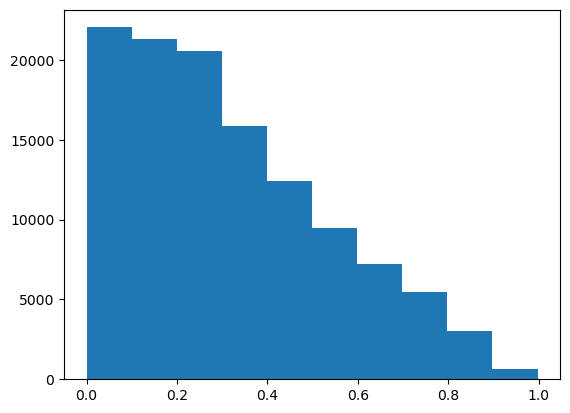

In [77]:
plt.hist(prediction)

plt.show()

In [78]:
roc_auc_score(y_test, prediction)

0.8373593039810412

In [79]:
from sklearn.metrics import confusion_matrix

In [80]:
df_test_metric = pd.DataFrame()
df_test_metric["score"] = prediction
df_test_metric["true"] = y_test.values

In [81]:
import math

In [82]:
df_test_metric["score_bin"] = df_test_metric["score"].apply(lambda x: math.floor(x * 10))

In [83]:
metrics_df = (
    df_test_metric.groupby("score_bin")["true"]
    .agg(["mean", "count", "sum"])
    .reset_index()
)
metrics_df["mean"] = round(metrics_df["mean"] * 100, 2)
metrics_df

,score_bin,mean,count,sum
0,0,0.10,22095,22
1,1,0.26,21333,56
2,2,0.59,20582,121
3,3,0.86,15904,137
4,4,1.48,12403,183
5,5,2.19,9448,207
6,6,3.82,7173,274
7,7,5.85,5438,318
8,8,10.68,2950,315
9,9,36.57,629,230
